# Halo model power spectra
This example illustrates how to use CCL to calculate power spectra using the halo model.

This notebook has to be run with `desc-python` kernel!!!

In [1]:
import sys
sys.path.append('/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/scripts/')
import HSCAnalysisUtils
import HSCMeasurementUtils as hmu

In [2]:
# Working kernel: desc-python !!!!!!!!!!!!!!!!!!!!!
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
from scipy.special import erf
# %matplotlib inline
import os 
import sacc
import datetime
import time

%matplotlib inline
colors = ['#000000', '#800080', '#008000', '#ff0000', "#E69F00", "#56B4E9", "#009E73", "#F0E442", '#800080', "#0072B2", "#CC79A7", "#D55E00", '#0000ff', '#ffa500', '#00ffff', '#800000', '#008080', '#808000', '#ff00ff', '#00ff00']

## Preliminaries
Generate a cosmology object and a couple of $k$ (comoving wavenumber) and $a$ (scale factor) arrays.

Planck cosmology 
$\Omega_{CDM} = 0.264$, $\Omega_b = 0.0493$, $h=0.6736$, $\sigma_8 = 0.8111$ and $n_s = 0.9649$

In [3]:
# Planck 2018 Cosmology
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.0493, h=0.6736, sigma8=0.8111, n_s=0.9649)

# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E1,256)
a_arr = np.linspace(0.1,1,64)

Let us also initialize a series of halo model quantities. We will need:
- A halo mass definition.
- A concentration-mass relation.
- A halo mass function parametrization.
- A halo bias parametrization.
- Halo profiles corresponding to the quantities we want to compute the power spectrum of.

In [4]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation (Checked - used in paper)
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function (Checked - used in paper)
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# # The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

Additionally, in order to showcase the flexibility of the current halo model implementation, let us create our own halo profile characterizing the galaxy overdensity using a Halo Occupation Distribution model. We will use the same parametrization used in Nicola et al. https://arxiv.org/abs/1912.08209.

In [12]:
pg = HSCAnalysisUtils.HaloProfileHOD(cM)

## Halo model power spectra

The halo-model power spectrum for two quantities defined by their halo profiles $u$ and $v$ is given by
\begin{equation}
   P_{uv}(k) = \int dM\,n(M)\,\langle u(k|M)\,v(k|M)\rangle + \left[\int dM\,n(M)\,b(M)\,\langle u(k|M)\rangle\right]\,\left[\int dM\,n(M)\,b(M)\,\langle v(k|M)\rangle\right]\,P_{\rm lin}(k).
\end{equation}

The first part, the so-called "one-halo" term, involves the Fourier-space two-point cumulant of the two profiles ($\langle u(k|M)\,v(k|M)\rangle$). This is often approximated by the product of the profile means ($\langle u(k|M)\rangle\,\langle v(k|M)\rangle$), but this is not correct in general (e.g. for the HOD profile). For this reason, the computation of the halo model power spectrum in CCL requires three main ingredients:
- The two profiles to be correlated.
- The linear matter power spectrum. Together with the profile means it controls the 2-halo term.
- The two-point cumulant of the two profiles, controlling the 1-halo term. By default we will set this to the product of the profile means, but we provide ways to define your own two-points.

Let's start by computing the different auto- and cross-correlations between matter and galaxy overdensities at $z=0$.

The first step is creating a `HMCalculator` object that essentially takes care of the mass integrals.

In [13]:
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m)

Now let's start computing the different power spectra. Note that, because we are interested in overdensities, we normalize by the means of both quantities. This is done by setting the `normprof` parameters of all method calls to `True`.

### 1. Matter-matter

In [14]:
pk_MM = ccl.halos.halomod_power_spectrum(cosmo, 
                                         hmc,
                                         k_arr,
                                         1.,
                                         pM,
                                         normprof1=True)

### 2. Galaxy-matter

In [15]:
pk_gM = ccl.halos.halomod_power_spectrum(cosmo = cosmo,
                                         hmc = hmc,
                                         k = k_arr,
                                         a = 1.,
                                         prof = pg,
                                         prof2 = pM,
                                         normprof1 = True,
                                         normprof2 = True)

### 3. Galaxy-galaxy

In this case we have a non-trivial two-point cumulant (see Eq. 3.9 of https://arxiv.org/abs/1909.09102). To deal with this we first create a `ProfileCovar` object that implements this.

In [16]:
HOD2pt = HSCAnalysisUtils.Profile2ptHOD()
    
pk_gg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1.,
                                         pg, prof_2pt=HOD2pt,
                                         normprof1=True)

OK, great, now let's plot the power spectra!

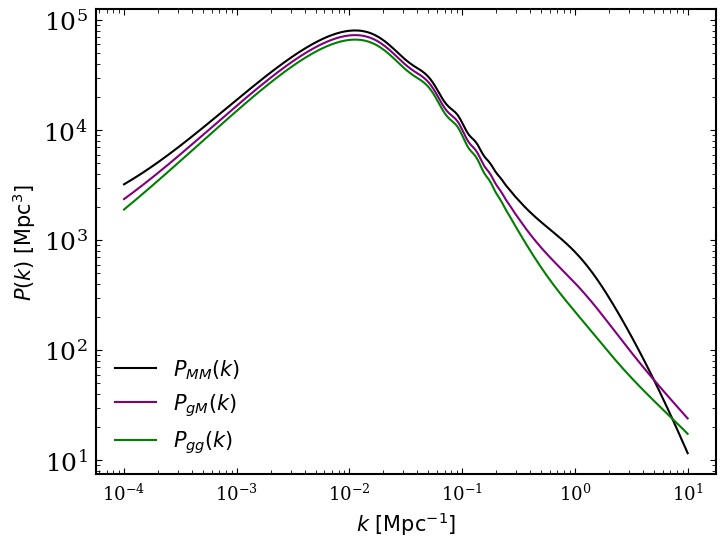

In [10]:
plt.figure()
plt.plot(k_arr, pk_MM, colors[0], label='$P_{MM}(k)$')
plt.plot(k_arr, pk_gM, colors[1], label='$P_{gM}(k)$')
plt.plot(k_arr, pk_gg, colors[2], label='$P_{gg}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', frameon=False, fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^3]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)

plt.show()
plt.close()

## 2D power spectra and $C_\ell$ s

The `HMCalculator` objects can also provide `Pk2D` power spectrum objects that can then be used to perform Limber integrals and compute angular power spectra. Let's do so for the 3D cross correlations we just looked at.

First, let's create two CCL tracers, a `NumberCountsTracer` that we will associate with the galaxy overdensity, and a `WeakLensing` tracer that we will associate with the matter overdensity.

Here we read the redshift distribution of the lens galaxy sample, similar to the one used in the galaxy clustering analysis presented in Nicola et al.

In [17]:
pk_ggf = ccl.halos.halomod_Pk2D(cosmo,
                                hmc,
                                pg,
                                prof_2pt=HOD2pt,
                                normprof1=True,
                                lk_arr=np.log(k_arr),
                                a_arr=a_arr)

# Save into a data-vector
Put this auto- and cross- correlations of the galaxy clustering in a Firecrown readable format.

Mimicking the sacc file generation process in https://github.com/LSSTDESC/sacc/blob/master/examples/Create_Sacc.ipynb

Adding lens dndz z-bin 1 ...
Adding lens dndz z-bin 2 ...
Adding lens dndz z-bin 3 ...
Adding lens dndz z-bin 4 ...


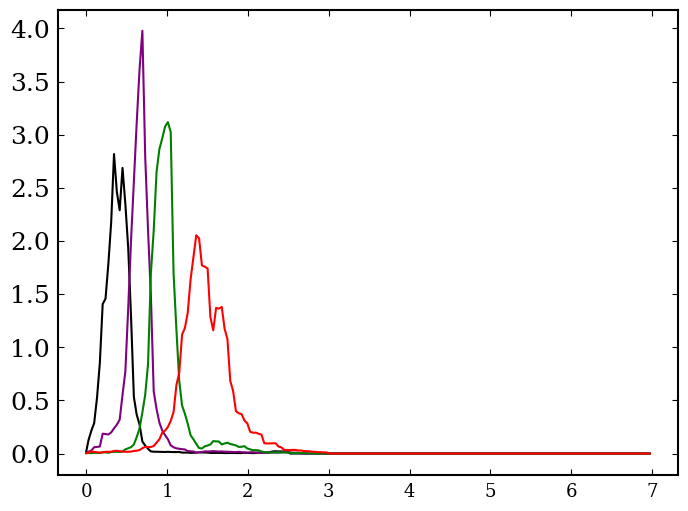

>> multipoles =  [ 149.5  249.5  349.5  499.5  699.5  899.5 1199.5 1599.5 1999.5]
>> Covariance matrix shape BEFORE removing GGL and Shear
(708, 708)
>> Covariance matrix shape AFTER removing GGL and Shear
(36, 36)
>> Length of the signal:  36
>> Introducing covariance matrix


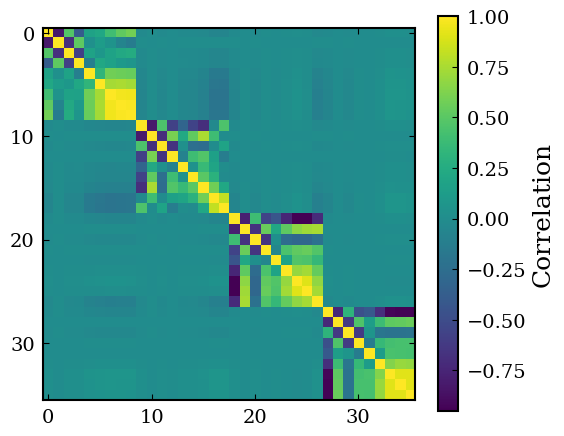

Z-BIN COMBINATION 0 0
z-bin = (0, 0), z_eff = 0.403
Comoving distance = 1616.12 Mpc
Z-BIN COMBINATION 1 1
z-bin = (1, 1), z_eff = 0.671
Comoving distance = 2501.84 Mpc
Z-BIN COMBINATION 2 2
z-bin = (2, 2), z_eff = 0.996
Comoving distance = 3395.27 Mpc
Z-BIN COMBINATION 3 3
z-bin = (3, 3), z_eff = 1.486
Comoving distance = 4463.22 Mpc


In [18]:
s = HSCAnalysisUtils.GenerateHODClustering(cosmo = cosmo,
                                           pk_ggf = pk_ggf,
                                           apply_scalecuts=False)

In [19]:
fname = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering/summary_statistics_clustering_hod_rsd.fits'
labels = 'HOD Clustering (Planck 2018 Cosmology)'

##########################################
    Plotting Clustering 2pt functions    
##########################################
>> Number of lens bins:  4
>> Do not show residuals
>> Initializing figure ...
>> Adding individual measurements
>> Plotting  HOD Clustering (Planck 2018 Cosmology)
DV with covariance
No noise to substract
No noise to substract
No noise to substract
No noise to substract
>> No combined measurement added
>>  Galaxy clustering - Nicola et al.


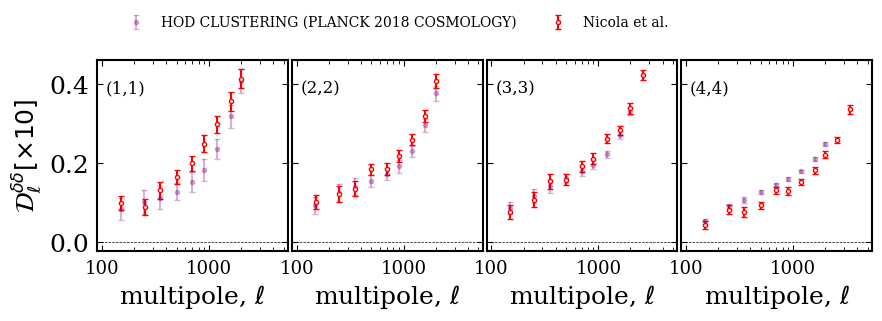

()

In [20]:
hmu.Clustering2pt_plot(fname = [fname],
                        labels = [labels], 
                        add_individual = True,
                        add_combined = False,
                        add_literature = True,
                        save_fig = False)

# Generate dv with scale cuts

In [21]:
# Planck 2018 Cosmology
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.0493, h=0.6736, sigma8=0.8111, n_s=0.9649)

In [22]:
# Read the full HOD data vector we have just generated above
fname = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering/summary_statistics_clustering_hod_rsd.fits'
s = sacc.Sacc.load_fits(fname) 

Generating HOD Clustering Data Vector with scale cuts


Adding lens dndz z-bin 1 ...
Adding lens dndz z-bin 2 ...
Adding lens dndz z-bin 3 ...
Adding lens dndz z-bin 4 ...


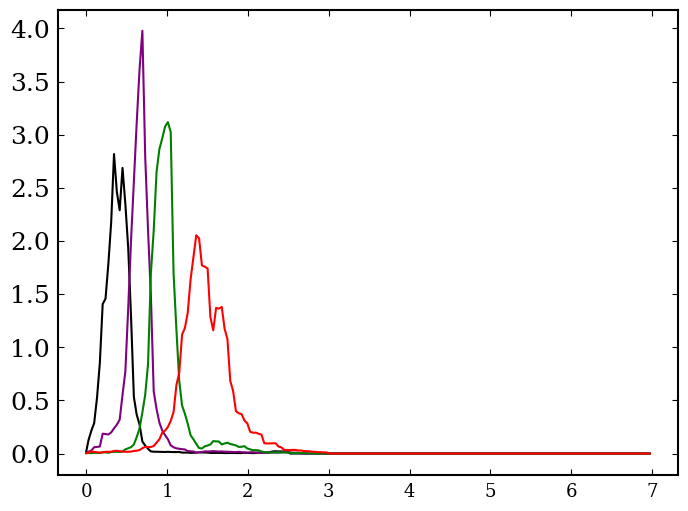

>> multipoles =  [ 149.5  249.5  349.5  499.5  699.5  899.5 1199.5 1599.5 1999.5]
>> Covariance matrix shape BEFORE removing GGL and Shear
(708, 708)
>> Covariance matrix shape AFTER removing GGL and Shear
(36, 36)
>> Length of the signal:  36
>> Introducing covariance matrix


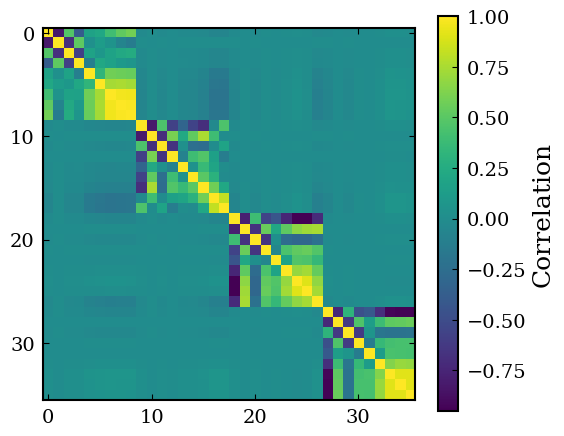

Z-BIN COMBINATION 0 0
z-bin = (0, 0), z_eff = 0.403
Comoving distance = 1616.12 Mpc
Z-BIN COMBINATION 1 1
z-bin = (1, 1), z_eff = 0.671
Comoving distance = 2501.84 Mpc
Z-BIN COMBINATION 2 2
z-bin = (2, 2), z_eff = 0.996
Comoving distance = 3395.27 Mpc
Z-BIN COMBINATION 3 3
z-bin = (3, 3), z_eff = 1.486
Comoving distance = 4463.22 Mpc
>> Producing DATA VECTORS with scale cuts
#######################
k_max = 1.5 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 2424
Correlation =  1 1
ell_max = 3752
Correlation =  2 2
ell_max = 5092
Correlation =  3 3
ell_max = 6694
Number of remaining data points:
Corr 00 = 9
Corr 11 = 9
Corr 22 = 9
Corr 33 = 9
>> Saving data vector ...
#######################
k_max = 1.0 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 1616
Correlation =  1 1
ell_max = 2501
Correlation =  2 2
ell_max = 3395
Correlation =  3 3
ell_max = 4463
Number of remaining data points:
Corr 00 = 8
Corr 11 = 9
Corr 22 = 9
Corr 33 = 9
>> Saving data vector ...


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-

Corr 22 = 6
Corr 33 = 7
>> Saving data vector ...
#######################
k_max = 0.25 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 404
Correlation =  1 1
ell_max = 625
Correlation =  2 2
ell_max = 848
Correlation =  3 3
ell_max = 1115
Number of remaining data points:
Corr 00 = 3
Corr 11 = 4
Corr 22 = 5
Corr 33 = 6
>> Saving data vector ...
#######################
k_max = 0.2 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 323
Correlation =  1 1
ell_max = 500
Correlation =  2 2
ell_max = 679
Correlation =  3 3
ell_max = 892
Number of remaining data points:
Corr 00 = 2
Corr 11 = 4
Corr 22 = 4
Corr 33 = 5
>> Saving data vector ...
#######################
k_max = 0.15 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 242
Correlation =  1 1
ell_max = 375
Correlation =  2 2
ell_max = 509
Correlation =  3 3
ell_max = 669
Number of remaining data points:
Corr 00 = 1
Corr 11 = 3
Corr 22 = 4
Corr 33 = 4
>> Saving data vector ...
#######################
k_

/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-

#######################
k_max = 0.06 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 96
Correlation =  1 1
ell_max = 150
Correlation =  2 2
ell_max = 203
Correlation =  3 3
ell_max = 267
Number of remaining data points:
Corr 00 = 0
Corr 11 = 1
Corr 22 = 1
Corr 33 = 2
>> Saving data vector ...
#######################
k_max = 0.05 [1/Mpc]
#######################
Correlation =  0 0
ell_max = 80
Correlation =  1 1
ell_max = 125
Correlation =  2 2
ell_max = 169
Correlation =  3 3
ell_max = 223
Number of remaining data points:
Corr 00 = 0
Corr 11 = 0
Corr 22 = 1
Corr 33 = 1
>> Saving data vector ...


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


In [30]:
generate = True

if generate == True:
    print('Generating HOD Clustering Data Vector with scale cuts')
    S = HSCAnalysisUtils.GenerateHODClustering(cosmo = cosmo,
                                            pk_ggf = pk_ggf,
                                            apply_scalecuts=True)

# Run minimizers
## Obtain best-fit linear galaxy bias

Calculations, looking for the best-fit using `maxlike` can be found in `/pscratch/sd/d/davidsan/new_firecrown/firecrown/examples/hsc_3x2pt/clustering/scale_cuts`

Also, running here the minimizers directly. We have checked that both, `scipy` run directly in the notebook and `Firecrown`, yield similar results.

In [31]:
import numpy as np
from scipy.optimize import minimize
import sacc 
import pyccl as ccl
import os
import matplotlib.pyplot as plt
import scipy

In [32]:
# Read one of the data vectors
path_dv = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering'

In [33]:
# Initialize the cosmology
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.0493, h=0.6736, sigma8=0.8111, n_s=0.9649)
print(cosmo.sigma8())

0.8111000000000004


In [34]:
# Define your objective function (negative log-likelihood)
def neg_log_likelihood(params):
    # Your likelihood calculation here
    data = np.array([])
    theory = np.array([])
    ell_array = np.array([])

    # bias_array = [1.0, 1.0, 1.0, 1.0]
    bias_array = np.copy(params)

    # Loop over the four lens bins, just auto-correlations
    for i in np.arange(4):
        # Extract the data and append
        ell, Cell_data = s.get_ell_cl(data_type = 'galaxy_density_cl', tracer1 = f'lens_{i}', tracer2 = f'lens_{i}')
        # Append the multipole information
        ell_array = np.append(ell_array, ell)
        # Append the signal to the data array
        data = np.append(data, Cell_data)    
        # Compute the theory prediction and append
        z = s.tracers[f'lens_{i}'].z
        nz = s.tracers[f'lens_{i}'].nz
        # Define bias as an array with the same length as z repeating bias_array[i]
        bias = np.repeat(bias_array[i], len(z))
        gals = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z, nz), bias=(z, bias))
        # Compute the theory prediction
        Cell_theory = ccl.angular_cl(cosmo, gals, gals, ell)
        # Append the signal to the theory array
        theory = np.append(theory, Cell_theory)

    # Extract the covariance matrix
    covmat = s.covariance.covmat

    # Compute the inverse covariance matrix
    inv_covmat = np.linalg.inv(covmat)

    # Compute the chi2
    chi2 = (data - theory) @ inv_covmat @ (data - theory)

    # Compute the negative log-likelihood
    nll = 0.5 * chi2

    return nll


In [35]:
# Initialize a scale_cut_bias_dict dictionary
scale_cut_bias_dict = {}
# Initialize a scale_cut_error_dict dictionary
scale_cut_error_dict = {}

kmax_array = np.array([0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

for kmax in kmax_array:
    # Read the corresponding data vector
    saccfile = os.path.join(path_dv, f'summary_statistics_clustering_hod_rsd_kmax_{kmax}.sacc')
    s = sacc.Sacc.load_fits(saccfile)

    # Print the number of data points and the kmax
    print('kmax = ', kmax)
    print('Number of data points = ', len(s.mean))

    # Run the optimization (Nelder-Mead in this case)
    result = minimize(neg_log_likelihood, [1.5, 1.5, 1.5, 2.0], method='L-BFGS-B')
    # print('Optimization result: ', result)

    # Save in the dictionary the result of the optimization
    scale_cut_bias_dict[kmax] = result.x

    # Compute the number of degrees of freedom
    # Number of data points minus number of bias parameters
    dof = len(s.mean) - 4

    # Chi2 calculation
    # Your likelihood calculation here
    data = np.array([])
    theory = np.array([])
    ell_array = np.array([])

    # bias_array = [1.0, 1.0, 1.0, 1.0]
    bias_array = np.copy(result.x)

    # Loop over the four lens bins, just auto-correlations
    for i in np.arange(4):
        # Extract the data and append
        ell, Cell_data = s.get_ell_cl(data_type = 'galaxy_density_cl', tracer1 = f'lens_{i}', tracer2 = f'lens_{i}')
        # Append the multipole information
        ell_array = np.append(ell_array, ell)
        # Append the signal to the data array
        data = np.append(data, Cell_data)    
        # Compute the theory prediction and append
        z = s.tracers[f'lens_{i}'].z
        nz = s.tracers[f'lens_{i}'].nz
        # Define bias as an array with the same length as z repeating bias_array[i]
        bias = np.repeat(bias_array[i], len(z))
        gals = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z, nz), bias=(z, bias))
        # Compute the theory prediction
        Cell_theory = ccl.angular_cl(cosmo, gals, gals, ell)
        # Append the signal to the theory array
        theory = np.append(theory, Cell_theory)

    # Extract the covariance matrix
    covmat = s.covariance.covmat

    # Compute the inverse covariance matrix
    inv_covmat = np.linalg.inv(covmat)

    # Compute the chi2
    chi2 = (data - theory) @ inv_covmat @ (data - theory)

    # Compute the p-value
    p_value = 1.0 - scipy.stats.chi2.cdf(chi2, dof)

    print(f'chi2 = {chi2}')
    print(f'dof = {dof}')
    print(f'p-value = {p_value}')

    plot = False

    if plot == True:

        # Plot the data and theory
        plt.figure()
        plt.plot(ell_array, data, 'k.', label='Data')
        plt.plot(ell_array, theory, 'r-', label='Theory')
        plt.xscale('log')
        plt.legend(loc='lower left', frameon=False, fontsize=15)
        plt.ylabel(r'$C_\ell$', fontsize=15)
        plt.xlabel(r'$\ell$', fontsize=15)
        plt.show()
        plt.close()

    # Compute the Hessian matrix
    hessian_matrix = result.hess_inv.todense()

    # Invert the Hessian matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(hessian_matrix)

    if plot == True:
        # Plot the covariance matrix
        plt.figure()    
        plt.imshow(covariance_matrix, cmap='RdBu_r')
        plt.colorbar()  
        plt.show()
        plt.close() 

    # Standard errors of the parameters
    std_errors = np.sqrt(np.diag(covariance_matrix))

    # Calculate confidence intervals (for example, 95% confidence interval)
    alpha = 0.05  # significance level
    z_critical = scipy.stats.norm.ppf(1 - alpha / 2)
    conf_intervals = np.column_stack((result.x - z_critical * std_errors, result.x + z_critical * std_errors))

    # Save in the dictionary the standard errors
    scale_cut_error_dict[kmax] = z_critical

    print('Done!')
print('Super Done!')


kmax =  0.07
Number of data points =  4


/global/common/software/lsst/gitlab/desc-python-prod/84904/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


chi2 = 0.011146573696012381
dof = 0
p-value = nan
Done!
kmax =  0.08
Number of data points =  6
chi2 = 0.011963532852945437
dof = 2
p-value = 0.9940360887188084
Done!
kmax =  0.09
Number of data points =  6
chi2 = 0.011963532852945437
dof = 2
p-value = 0.9940360887188084
Done!
kmax =  0.1
Number of data points =  8
chi2 = 0.018605551810093362
dof = 4
p-value = 0.999956996605526
Done!
kmax =  0.15
Number of data points =  12
chi2 = 0.3193763841467179
dof = 8
p-value = 0.9999761467462089
Done!
kmax =  0.2
Number of data points =  15
chi2 = 1.3333041743032563
dof = 11
p-value = 0.9997867041930775
Done!
kmax =  0.25
Number of data points =  18
chi2 = 2.7728026525804266
dof = 14
p-value = 0.9994119787097865
Done!
kmax =  0.3
Number of data points =  21
chi2 = 7.7747244943772
dof = 17
p-value = 0.9711292481244597
Done!
kmax =  0.4
Number of data points =  25
chi2 = 20.980278614324362
dof = 21
p-value = 0.46014919056075343
Done!
kmax =  0.5
Number of data points =  29
chi2 = 44.44849751769119

# Choice of the maximum scale

Considering two different factors:
- Goodness-of-fit, $\chi^2$
- Best-fit linear galaxy bias vs. input linear galaxy bias
we choose up to which scale, the linear galaxy bias is a good description of our galaxy clustering.

In [36]:
zeff_dict, chi_dict = HSCAnalysisUtils.zEffective_Comoving_Dist_Calculation(s = s, cosmo = cosmo)

Z-BIN COMBINATION 0 0
z-bin = (0, 0), z_eff = 0.403
Comoving distance = 1616.12 Mpc
Z-BIN COMBINATION 1 1
z-bin = (1, 1), z_eff = 0.671
Comoving distance = 2501.84 Mpc
Z-BIN COMBINATION 2 2
z-bin = (2, 2), z_eff = 0.996
Comoving distance = 3395.27 Mpc
Z-BIN COMBINATION 3 3
z-bin = (3, 3), z_eff = 1.486
Comoving distance = 4463.22 Mpc


In [37]:
for i in np.arange(4):
    print('zeff bin %d = %.3f'%(i + 1, zeff_dict[f'{i}_{i}']))
    print('chi bin %d = %.3f in Mpc'%(i + 1, chi_dict[f'{i}_{i}']))

zeff bin 1 = 0.403
chi bin 1 = 1616.123 in Mpc
zeff bin 2 = 0.671
chi bin 2 = 2501.838 in Mpc
zeff bin 3 = 0.996
chi bin 3 = 3395.268 in Mpc
zeff bin 4 = 1.486
chi bin 4 = 4463.217 in Mpc


In the next cell there were nice plots with the mock data and the best-fit theory prediction BUT these were obtained from the run with Firecrown, which is not exactly what we are using.

In [38]:
""" path_to_save = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/figures/measurements/clustering/scale_cuts'

# kmax_array = np.array([0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5])

# Initialize an empty dictionary where to save bias values with k_max as key
scale_cut_bias_dict = dict()

# Initialize where to read information
path_dv = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering'
# Extract best-fit linear galaxy bias for each k_max case
path_bestfit = '/pscratch/sd/d/davidsan/new_firecrown/firecrown/examples/hsc_3x2pt/clustering/scale_cuts/output'

# Let's read the whole HOD mock signal just for plotting
fname_plot = os.path.join(path_dv, f'summary_statistics_clustering_hod_rsd.fits')
s_plot = sacc.Sacc.load_fits(fname_plot)

g = open('chisq_info_rsd.txt','w')
g.write('** Analysing the goodness-of-fit of linear galaxy bias with HOD data to design clustering scale cuts ** \n')
for k_max in kmax_array:
    g.write('\n')
    g.write(f'kmax = {k_max} \n')
    g.write('\n')
    # Read HOD mock signal
    sacc_fname = os.path.join(path_dv, f'summary_statistics_clustering_hod_rsd_kmax_{k_max}.sacc')
    # Read HOD best-fit prediction
    theory_fname = os.path.join(path_bestfit, f'output_clustering_GC_k_{k_max}/best-fit/data_vector')
    fname_bestfit = os.path.join(path_bestfit, f'output_clustering_GC_k_{k_max}/best-fit/firecrown_two_point/values.txt')
    # Read fname_bestfit txt file
    f = open(fname_bestfit, 'r')
    lines = f.readlines()
    # Initialize bias variable
    lbias_arr = np.array([])
    for line in lines:
        if 'bias' in line:
            # Extract the number from the string
            bias = float(line.split(' ')[-1])
            lbias_arr = np.append(lbias_arr, bias)
    f.close()
    # Save in the dictionary lbias_arr with k_max as key
    scale_cut_bias_dict[k_max] = lbias_arr
    # print(lbias_arr)    
    # Compute the maximum multipole for each z-bin pair
    l_max = HSCAnalysisUtils.Kmax_to_Ellmax(kmax = k_max, chi_dict = chi_dict)
    # print(l_max)
    
    print('############################################')
    print(f'###      kmax = {k_max} Mpc^-1          ###')
    print('############################################')
    
    nbins_lens = 4
    fig, axs = plt.subplots(1, nbins_lens, sharex=True, sharey='row', figsize=(10,3))
    fig.tight_layout()

    plt.subplots_adjust(wspace=0, hspace=0)

    for i in np.arange(nbins_lens):

        # To Plot all data points
        ell_plot, Cell_plot, cov_plot = s_plot.get_ell_cl('galaxy_density_cl', f'lens_{i}', f'lens_{i}', return_cov=True)
        err_plot = np.sqrt(np.diag(cov_plot))
        # Compute the prefactor
        pref = ell_plot * (ell_plot + 1) / (2 * np.pi) * 10 ** 2
        # Apply the prefactor
        Cell_plot = Cell_plot * pref
        err_plot = err_plot * pref
        axs[i].errorbar(ell_plot, Cell_plot, yerr=err_plot,
                        color=colors[0], 
                        fmt='o', 
                        markersize=3.0, 
                        capsize=2)

        # To plot the best-fit theory prediction
        ell_bf = np.loadtxt(os.path.join(theory_fname, f'ell_or_theta_galaxy_density_cl_lens_{i}_lens_{i}.txt'))
        Cell_bf = np.loadtxt(os.path.join(theory_fname, f'theory_galaxy_density_cl_lens_{i}_lens_{i}.txt'))
        # Compute the prefactor
        pref = ell_bf * (ell_bf + 1) / (2 * np.pi) * 10 ** 2
        # Apply the prefactor
        Cell_bf = Cell_bf * pref
        axs[i].plot(ell_bf, Cell_bf, color=colors[0], lw=1.5)


        # print(len(Cell_meas))
        axs[i].set_xscale('log')
        # axs[i].loglog()
        axs[i].set_xticks([1e2,1e3],['100','1000'])
        # Plot the scale cuts
        axs[i].axvspan(l_max[f'{i}_{i}'], 2300, alpha=0.2, color='grey')
        axs[i].set_xlim(100, 2300)

        # z-bin pair
        axs[i].text(0.15, 0.85,f'({i+1},{i+1})', ha='center', va='center', transform=axs[i].transAxes, fontsize=10)
        axs[i].text(0.18, 0.75,f'b$^{i+1}$={np.round(lbias_arr[i], 2)}', ha='center', va='center', transform=axs[i].transAxes, fontsize=8)

        if i == 0:
            axs[i].set_ylabel('$\mathcal{D}^{HOD}_\ell \, [\\times 10^2]$', fontsize=18)

        axs[i].set_xlabel('multipole $\ell$', fontsize=15)

    ###################
    # Goodness-of-fit #
    ###################
    probe = 'galaxy_density_cl'
    npar = 4 # minimizing to obtain linear galaxy bias parameters
    chisq, chisq_ndof, ndof = hmu.ComputeChisq(sacc_fname = sacc_fname, 
                                                theory_fname = theory_fname, 
                                                probe = probe, 
                                                npar = npar)

    print(f'Degrees-of-freedom = {ndof}')
    g.write(f'Degrees-of-freedom = {ndof} \n')
    print(f'Chisq = {np.round(chisq, 2)}')
    g.write(f'Chisq = {np.round(chisq, 2)} \n')
    print(f'Chisq / ndof = {np.round(chisq_ndof, 2)}') 
    g.write(f'Chisq / ndof = {np.round(chisq_ndof, 2)} \n')   
    g.write('\n')
 
    axs[3].text(0.7, 0.85, f'$\\chi^2 / \\nu = {np.around(chisq, 2)}/{ndof}$', ha='center', va='center', transform=axs[3].transAxes, fontsize=9)

    axs[3].legend(loc='upper left', fontsize=6, frameon=False)
    
    kmax_str=f'k={k_max} [1/Mpc]'
    axs[0].text(0.7, 0.85, kmax_str, ha='center', va='center', transform=axs[0].transAxes, fontsize=8, bbox=dict(edgecolor='black', facecolor='none'))

    plt.savefig(os.path.join(path_to_save, f'sc_rsd_k_max_{k_max}.png'),
               dpi=300,
               bbox_inches='tight')
    
    plt.savefig(os.path.join(path_to_save, f'sc_rsd_k_max_{k_max}.pdf'),
               dpi=300,
               bbox_inches='tight') 
plt.show
f.close()  """

" path_to_save = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/figures/measurements/clustering/scale_cuts'\n\n# kmax_array = np.array([0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5])\n\n# Initialize an empty dictionary where to save bias values with k_max as key\nscale_cut_bias_dict = dict()\n\n# Initialize where to read information\npath_dv = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/hod_clustering'\n# Extract best-fit linear galaxy bias for each k_max case\npath_bestfit = '/pscratch/sd/d/davidsan/new_firecrown/firecrown/examples/hsc_3x2pt/clustering/scale_cuts/output'\n\n# Let's read the whole HOD mock signal just for plotting\nfname_plot = os.path.join(path_dv, f'summary_statistics_clustering_hod_rsd.fits')\ns_plot = sacc.Sacc.load_fits(fname_plot)\n\ng = open('chisq_info_rsd.txt','w')\ng.write('** Analysing the goodness-of-fit of linear galaxy bias with HOD data to design clustering scale cuts ** \n')\nfo

# Halo bias: computing linear galaxy bias coefficients

Calculation taken from the original notebook `/pscratch/sd/d/davidsan/3x2pt-HSC/HSC-3x2pt-methods/scale_cuts/hod_clustering_scale_cuts/Halo_Bias.ipynb`

In [40]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
from scipy.special import erf
%matplotlib inline
import os 
import sacc
import datetime
import time
from scipy.integrate import simps

In [41]:
# Planck 2018 Cosmology
cosmo = ccl.Cosmology(Omega_c=0.264, Omega_b=0.0493, h=0.6736, sigma8=0.8111, n_s=0.9649)

# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E1,256)
a_arr = np.linspace(0.1,1,64)

In [42]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation (Checked - used in paper)
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function (Checked - used in paper)
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# # The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

In [43]:
class HaloProfileHOD(ccl.halos.HaloProfileNFW):
    def __init__(self, c_M_relation,
                 lMmin=12.02, lMminp=-1.34,
                 lM0=6.6, lM0p=-1.43,
                 lM1=13.27, lM1p=-0.323):
        self.lMmin=lMmin
        self.lMminp=lMminp
        self.lM0=lM0
        self.lM0p=lM0p
        self.lM1=lM1
        self.lM1p=lM1p
        # Pivot is z_p = 0.65
        self.a0 = 1./(1+0.65)
        self.sigmaLogM = 0.4
        self.alpha = 1.
        super(HaloProfileHOD, self).__init__(c_M_relation)
        self._fourier = self._fourier_analytic_hod

    def _lMmin(self, a):
        return self.lMmin + self.lMminp * (a - self.a0)

    def _lM0(self, a):
        return self.lM0 + self.lM0p * (a - self.a0)

    def _lM1(self, a):
        return self.lM1 + self.lM1p * (a - self.a0)

    def _Nc(self, M, a):
        # Number of centrals
        Mmin = 10.**self._lMmin(a)
        return 0.5 * (1 + erf(np.log(M / Mmin) / self.sigmaLogM))

    def _Ns(self, M, a):
        # Number of satellites
        M0 = 10.**self._lM0(a)
        M1 = 10.**self._lM1(a)
        return np.heaviside(M-M0,1) * ((M - M0) / M1)**self.alpha

    def _fourier_analytic_hod(self, cosmo, k, M, a, mass_def):
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)

        Nc = self._Nc(M_use, a)
        Ns = self._Ns(M_use, a)
        # NFW profile
        uk = self._fourier_analytic(cosmo, k_use, M_use, a, mass_def) / M_use[:, None]

        prof = Nc[:, None] * (1 + Ns[:, None] * uk)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

    def _fourier_variance(self, cosmo, k, M, a, mass_def):
        # Fourier-space variance of the HOD profile
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)

        Nc = self._Nc(M_use, a)
        Ns = self._Ns(M_use, a)
        # NFW profile
        uk = self._fourier_analytic(cosmo, k_use, M_use, a, mass_def) / M_use[:, None]

        prof = Ns[:, None] * uk
        prof = Nc[:, None] * (2 * prof + prof**2)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

pg = HaloProfileHOD(cM)

In [44]:
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m)

In [45]:
class Profile2ptHOD(ccl.halos.Profile2pt):
    def fourier_2pt(self, prof, cosmo, k, M, a,
                      prof2=None, mass_def=None):
        return prof._fourier_variance(cosmo, k, M ,a, mass_def)
HOD2pt = Profile2ptHOD()
    
pk_gg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1.,
                                         pg, prof_2pt=HOD2pt,
                                         normprof1=True)

In [46]:
# Initialize an empty array to store the effective redshift values
zeff = np.array([])

# Iterate over the range of 4
for i in np.arange(4):
    # Append the effective redshift value for each z-bin pair to the 'zeff' array
    zeff = np.append(zeff, zeff_dict[f'{i}_{i}']) 

In [47]:
for i in np.arange(4):
    print('Effective redshift for bin %d = %.3f'%(i + 1, zeff[i]))

Effective redshift for bin 1 = 0.403
Effective redshift for bin 2 = 0.671
Effective redshift for bin 3 = 0.996
Effective redshift for bin 4 = 1.486


In [48]:
def halo_mass(z, ind):
    # ind can be 'min', '0' or '1'
    z_piv = 0.65
    
    if ind == 'min':
        # best fit values from Andrina's paper
        mu = 12.02
        mup = -1.34
        
    elif ind == '0':
        mu = 6.6
        mup = -1.43
        
    elif ind == '1':
        mu = 13.27
        mup = -0.323
        
    logM = mu + mup * (1 / (1 + z) - 1 / (1 + z_piv))
    M = 10 ** logM
    
    return(M)

In [49]:
# These are the values of the effective redshift and linear galaxy bias from the HOD obtained previous to setting in the lens sample nz(z > 2.5) = 0

# Define here the effective redshift for each z-bin pair
# zeff = np.array([0.584, 0.774, 1.004, 1.495])
# Corresponding halo masses galaxy bias
# gbias = np.array([1.31, 1.48, 1.71, 2.31])

In [53]:
# Initialize empty array to save the linear galaxy bias
gal_lbias = np.array([])
for z in zeff:
    print('*****************************************************')
    print(f'Computing linear galaxy bias at z = {np.round(z,2)}')
    print('*****************************************************')
    M0 = halo_mass(z=z, ind='0')
    print(f'Minimal galaxy mass M0 = 10^({np.round(np.log10(M0),2)})')
    m_arr =  np.logspace(np.log10(M0),17,128)
    # Compute the mass function
    distr_M = nM.get_mass_function(cosmo=cosmo,M=m_arr,a=1/(1+z))
    #Compute the number of centrals and satellites
    Nc = pg._Nc(M=m_arr, a=1/(1+z))
    Ns = pg._Ns(M=m_arr, a=1/(1+z))
    # Compute the mean number density of galaxies
    integrando = distr_M * Nc * (1 + Ns)
    ngal = simps(integrando, x=np.log10(m_arr))
    print(f'ngal = {np.round(ngal, 5)}')
    # Compute the halo bias
    halo_bias = bM.get_halo_bias(cosmo=cosmo, M=m_arr, a=1/(1+z))
    integrando = distr_M * halo_bias * Nc * (1 + Ns)
    integral = simps(integrando, x=np.log10(m_arr))
    
    bias = integral / ngal
    # Append the linear galaxy bias to the empty array
    gal_lbias = np.append(gal_lbias, bias)
    print(f'gbias = {np.round(bias, 4)}')

*****************************************************
Computing linear galaxy bias at z = 0.4
*****************************************************
Minimal galaxy mass M0 = 10^(6.45)
ngal = 0.00329
gbias = 1.1736
*****************************************************
Computing linear galaxy bias at z = 0.67
*****************************************************
Minimal galaxy mass M0 = 10^(6.61)
ngal = 0.00225
gbias = 1.3871
*****************************************************
Computing linear galaxy bias at z = 1.0
*****************************************************
Minimal galaxy mass M0 = 10^(6.75)
ngal = 0.00147
gbias = 1.6997
*****************************************************
Computing linear galaxy bias at z = 1.49
*****************************************************
Minimal galaxy mass M0 = 10^(6.89)
ngal = 0.00076
gbias = 2.2999


## Consistency plot

Compare input galaxy bias in mocks, computed above, wrt to bias coefficients obtained from minimizers.

Calculation taken from `/pscratch/sd/d/davidsan/3x2pt-HSC/HSC-3x2pt-methods/GalaxyClustering/bias_lens_consistency/bias_consistency_check_withRSD.ipynb`

In [54]:
# Bias obtained in previous section (see output in cell above)
# gal_lbias = [1.3132354253451917, 1.4786206734880059, 1.7089655279482314, 2.3121410614338616]

# Setting nz[z > 2.5] = 0.0
print(np.round(gal_lbias,4))


[1.1736 1.3871 1.6997 2.2999]


[1.12222275 1.37828375 1.66575671 2.27132206]
[1.12222224 1.36162045 1.64377039 2.27235431]
[1.08270293 1.32249369 1.64377044 2.27079139]
[1.04132468 1.32249368 1.62052833 2.26862739]
[1.04132398 1.28201274 1.59794263 2.26715238]
[0.97325964 1.24800528 1.56259767 2.27297122]
[0.9251753  1.20327582 1.54129885 2.28662611]
[0.89585859 1.20327641 1.5334366  2.28662616]
[0.89586209 1.18177951 1.53343678 2.28662634]
[0.87172472 1.17632574 1.53343691 2.28662616]
[0.87172472 1.17632574 1.53343691 2.28662616]
[0.87080076 1.17632582 1.53343692 2.28662614]
2


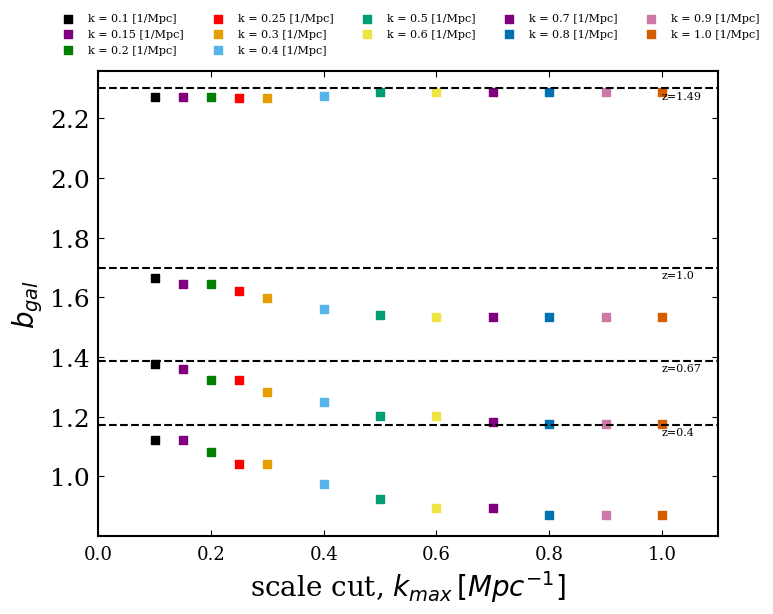

In [64]:
from matplotlib.colors import ListedColormap

cind = 0

f=open('galbias_criteria_rsd.txt','w')
f.write('Distance between the theoretical linear galaxy bias and the one obtained \n')
f.write('with the minimizer defined as the sqrt of the quadratic sum \n')

# Data vectors with [0.05, 0.06] have no remaining data points after scale cuts
kmax_array = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

cind = 0
for k_max in kmax_array:
    bias = scale_cut_bias_dict[k_max]
    print(bias)
    
    # Define a distance between theoretical values and the ones obtained with the minimizer
    dist = np.sqrt(sum(el*el for el in np.array(bias) - np.array(gal_lbias)))
    f.write(f'kmax = {k_max} Mpc^-1 -> dist(th,pred) = {np.round(dist,2)}\n')
    # print(dist)

    for i in np.arange(4):
        if i == 0:
            plt.scatter(k_max, bias[i], color=colors[cind], marker='s', label=f'k = {k_max} [1/Mpc]')
        else:
            plt.scatter(k_max, bias[i], color=colors[cind], marker='s')
            
    cind += 1

    
f.write('\n')
# for i in np.arange(4):
#     plt.axhline(b_theo[i], xmin=0.0, xmax=1.6, ls='--', color='k')
#     plt.axhspan(b_theo[i]-b_theo_err[i]**2, b_theo[i]+b_theo_err[i]**2, color='grey', alpha=0.3)
    
for i in np.arange(4):
    plt.axhline(gal_lbias[i], xmin=0.0, xmax=1.1, ls='--', color='k')
    plt.text(1.0, gal_lbias[i]-0.035, f'z={np.round(zeff[i],2)}',fontsize=8)
    f.write(f'z-bin {i+1} = {np.round(gal_lbias[i],2)} \n')
    
f.close()
print('2')
# plt.xticks(kmax_array, kmax_array, fontsize=16)
plt.xlim([0.0,1.1])
plt.xlabel('scale cut, $k_{max}\, [Mpc^{-1}]$',fontsize=20)
plt.ylabel('$b_{gal}$',fontsize=20)
#plt.ylabel('linear galaxy bias, $b_{gal}$')
plt.legend(bbox_to_anchor=(0.5,1.08),loc='center',ncol=5, frameon=False, fontsize=8) 

""" plt.savefig(os.path.join('bias_lenses_scale_cuts_rsd.png'),
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.savefig(os.path.join('bias_lenses_scale_cuts_rsd.pdf'),
            dpi=300,
            bbox_inches='tight')  """

plt.show()
plt.close()

[1.12222275 1.37828375 1.66575671 2.27132206]
[1.12222224 1.36162045 1.64377039 2.27235431]
[1.08270293 1.32249369 1.64377044 2.27079139]
[1.04132468 1.32249368 1.62052833 2.26862739]
[1.04132398 1.28201274 1.59794263 2.26715238]
[0.97325964 1.24800528 1.56259767 2.27297122]
[0.9251753  1.20327582 1.54129885 2.28662611]
[0.89585859 1.20327641 1.5334366  2.28662616]
[0.89586209 1.18177951 1.53343678 2.28662634]
[0.87172472 1.17632574 1.53343691 2.28662616]
[0.87172472 1.17632574 1.53343691 2.28662616]
[0.87080076 1.17632582 1.53343692 2.28662614]


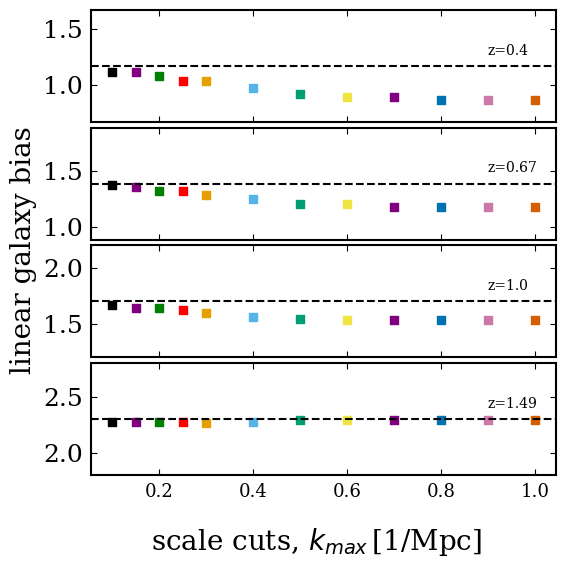

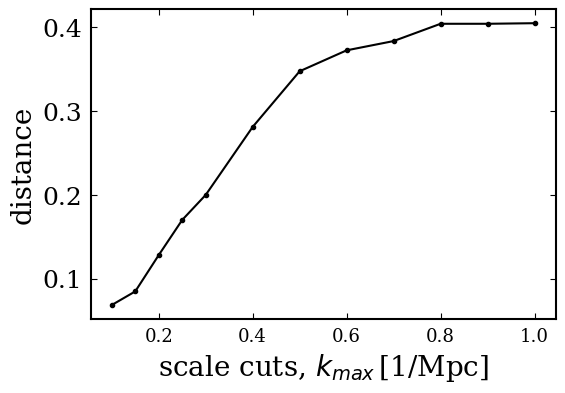

In [91]:
# Initialize an empty matplolib figure with 1 column and 4 rows with a shared x-axis, not sharing y-axis, small vertical space between subplots, height ratio of 1:1:1:1 and a figure size of 10x10
fig, axs = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(6,6), gridspec_kw={'hspace': 0.05, 'height_ratios': [1, 1, 1, 1]})

# "Linear galaxy bias" is the common y label
fig.text(-0.01, 0.5, 'linear galaxy bias', va='center', rotation='vertical', fontsize=20)
# "Scale cuts, $k_{max}\,$[1/Mpc]" is the common x label
fig.text(0.5, 0.0, 'scale cuts, $k_{max}\,$[1/Mpc]', ha='center', fontsize=20)

kmax_array = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Initialize an empty array to save the distance between the theoretical linear galaxy bias and the one obtained with the minimizer
dist_array = np.array([])

cind = 0
for k_max in kmax_array:
    bias = scale_cut_bias_dict[k_max]
    print(bias)
    # Define a distance between theoretical values and the ones obtained with the minimizer
    dist = np.sqrt(sum(el*el for el in np.array(bias) - np.array(gal_lbias)))
    # Append the distance to the empty array
    dist_array = np.append(dist_array, dist)

    for i in np.arange(4):
        if i == 0:
            axs[i].scatter(k_max, bias[i], color=colors[cind], marker='s', label=f'k = {k_max} [1/Mpc]')
        else:
            axs[i].scatter(k_max, bias[i], color=colors[cind], marker='s')
            
    cind += 1

# For each panel, plot the theoretical value of the linear galaxy bias as a horizontal line
for i in np.arange(4):
    axs[i].axhline(gal_lbias[i], xmin=0.0, xmax=1.1, ls='--', color='k')
    # Set the effective redshift as text in each panel on the top right corner
    axs[i].text(0.90, gal_lbias[i]+0.1, f'z={np.round(zeff[i],2)}',fontsize=10)
    
    # Set y limits on each panel so that the theoretical value of the linear galaxy bias is always centered
    axs[i].set_ylim([gal_lbias[i]-0.5, gal_lbias[i]+0.5])

plt.show()
plt.close()

# Initialize a rectangle matplotlib figure 
fig = plt.figure(figsize=(6,4))

# for each k_max, plot the distance between the theoretical linear galaxy bias and the one obtained with the minimizer
plt.plot(kmax_array, dist_array, color='k', marker='o', markersize=3.0)
# xlabel
plt.xlabel('scale cuts, $k_{max}\,$[1/Mpc]', fontsize=20)
# ylabel
plt.ylabel('distance', fontsize=20)
plt.show()
plt.close()


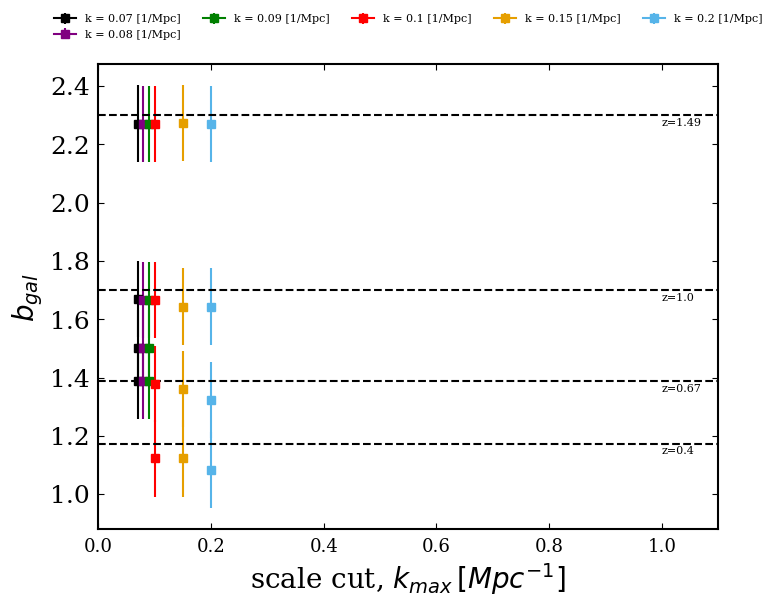

In [60]:
from matplotlib.colors import ListedColormap

cind = 0

# Data vectors with [0.05, 0.06] have no remaining data points after scale cuts
kmax_array = np.array([0.07, 0.08, 0.09, 0.1, 0.15, 0.2])#, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) #, 1.5])

# Weird recovered galaxy bias coming from not setting nz[z>2.5] = 0.0 !!!
# zeff = np.array([0.584, 0.774, 1.004, 1.495]) these were the effective redshifts
# gal_lbias = [1.3132354253451917, 1.4786206734880059, 1.7089655279482314, 2.3121410614338616] and the recovered galaxy bias

# Setting nz[z>2.5] = 0.0
# zeff = np.array([0.4028431515986678, 0.6691070280332916, 0.9940265246170689, 1.475187333331522])
# gbias = np.array([1.1736115530352245, 1.3851113022133323, 1.6980851939368058, 2.284952430623374])

for k_max in kmax_array:
    # Read the minimized galaxy bias
    bias = scale_cut_bias_dict[k_max]
    # and its error
    err = scale_cut_error_dict[k_max] / 15
    # Define a distance between theoretical values and the ones obtained with the minimizer
    dist = np.sqrt(sum(el*el for el in np.array(bias) - np.array(gal_lbias)))
    for i in np.arange(4):
        if i == 0:
            plt.errorbar(k_max, bias[i], yerr=err, color=colors[cind], marker='s', label=f'k = {k_max} [1/Mpc]')
        else:
            plt.errorbar(k_max, bias[i], yerr=err, color=colors[cind], marker='s')
            
    cind += 1
    
for i in np.arange(4):
    plt.axhline(gal_lbias[i], xmin=0.0, xmax=1.1, ls='--', color='k')
    plt.text(1.0, gal_lbias[i]-0.035, f'z={np.round(zeff[i],2)}',fontsize=8)
    
plt.xlim([0.0,1.1])
plt.xlabel('scale cut, $k_{max}\, [Mpc^{-1}]$',fontsize=20)
plt.ylabel('$b_{gal}$',fontsize=20)
plt.legend(bbox_to_anchor=(0.5,1.08),loc='center',ncol=5, frameon=False, fontsize=8) 

""" plt.savefig(os.path.join('bias_lenses_scale_cuts_rsd.png'),
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.savefig(os.path.join('bias_lenses_scale_cuts_rsd.pdf'),
            dpi=300,
            bbox_inches='tight')  """

plt.show()
plt.close()

# Bias lenses consistency check

The goal of this notebook is to check the consistency between the bias parameters estimation via MCMC and the expression presented in arxiv.org/pdf/1912.08209.



~~We are considering the same redshift intervals as the HSC analysis presented in Hamana et al. 2020. The z-intervals and the bias we find at each interval are~~

*   ~~0.3<z<0.6 \; \to \; b_0 = 1.000~~
*   ~~0.6<z<0.9 \; \to \; b_1 = 1.451~~
*   ~~0.9<z<1.2 \; \to \; b_2 = 1.922~~
*   ~~1.2<z<1.5 \; \to \; b_3 = 1.784~~
    
~~WARNING -- these estimations are VERY preliminary, obtained via MCMC with a linear IA model, linear bias and no scale cuts in the datavectors~~

For the "analytical" prescription, we are considering the one presented in Nicola et al. (the reference at the top)

\begin{equation}
    b(z,m_{lim}) = \bar{b}(m_{lim})D(z)^\alpha
\end{equation}

\begin{equation}
    \alpha = -1.30 \pm 0.19 \; \; \text{and} \; \; \bar{b}(m_{lim}) = b_1(m_{lim} - 24) + b_0
\end{equation}

equation 4.12 and 4.11 respectively. The fit parameters are $b_1 = -0.0624 \pm 0.0070$ and $b_0 = 0.8346 \pm 0.161$. We are considering for the calculation the i-band limiting magnitude from HSC analysis $m_{lim} = 24.5$.

Comentario de Andrina: fiarse más de los valores de la predicción teórica del galaxy bias que sale del HOD model antes que de la expresión que depende de la limiting magnitude.

In [2]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import os 

In [3]:
# Effective redshifts for Andrina´s lens sample
z = np.array([0.584, 0.773, 1.004, 1.495])
a = 1 / (1 + z)

In [4]:
# Planck 2018 cosmological parameters
cosmo = ccl.Cosmology(Omega_b=0.0493, Omega_c=0.264, n_s=0.9649, sigma8=0.8111, h=0.6736)

In [5]:
# Computing the growth factor D_+ for Planck 2018 cosmology at the same redshifts as the data.
growth_fact = ccl.growth_factor(cosmo=cosmo, a=a)

In [6]:
# Model parameters 
b1 = -0.0624
b1_error = 7e-03
b0 = 0.8346
b0_error = 1.61e-01
alpha = -1.30
alpha_error = 1.0e-01

# Limiting magnitude (specific for the HSC analysis)
mlim = 24.5

In [7]:
bbar = b1*(mlim - 24) + b0
b_theo = bbar*growth_fact**alpha

In [8]:
print('Linear galaxy bias predicted')
print(b_theo)

Linear galaxy bias predicted
[1.19314848 1.34358437 1.53970089 1.99272188]


Text(0, 0.5, 'bias lenses')

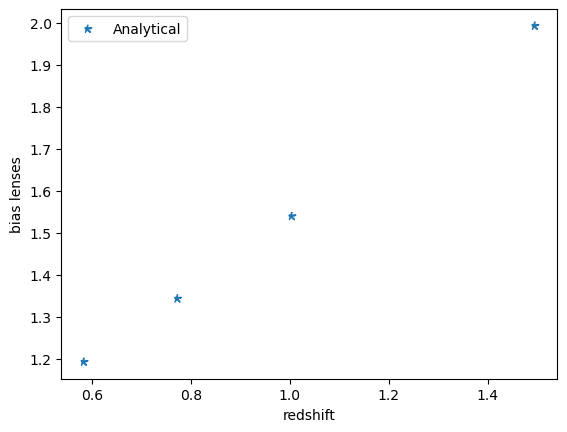

In [9]:
plt.scatter(z, b_theo, linestyle='--', marker='*', label='Analytical')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('bias lenses')

In [10]:
b_theo

array([1.19314848, 1.34358437, 1.53970089, 1.99272188])